In [2]:
!pip install sdv --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 323.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 249.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 298.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 304.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 287.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 346.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 313.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 249.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 259.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 292.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 270.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from sdv.datasets.local import load_csvs
from sdv.lite import SingleTablePreset
from sdv.metadata import SingleTableMetadata
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load your dataset
df = pd.read_csv("carclaims_updated.csv")
df.drop(columns=['RepNumber', 'PolicyNumber'], axis=1, inplace=True)

# Create metadata (autodetect types, but we'll also override for clarity)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)


In [10]:
metadata


{
    "columns": {
        "Month": {
            "sdtype": "categorical"
        },
        "WeekOfMonth": {
            "sdtype": "categorical"
        },
        "DayOfWeek": {
            "sdtype": "categorical"
        },
        "Make": {
            "sdtype": "categorical"
        },
        "AccidentArea": {
            "sdtype": "categorical"
        },
        "DayOfWeekClaimed": {
            "sdtype": "categorical"
        },
        "MonthClaimed": {
            "sdtype": "categorical"
        },
        "WeekOfMonthClaimed": {
            "sdtype": "categorical"
        },
        "Sex": {
            "sdtype": "categorical"
        },
        "MaritalStatus": {
            "sdtype": "categorical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "Fault": {
            "sdtype": "categorical"
        },
        "PolicyType": {
            "sdtype": "categorical"
        },
        "VehicleCategory": {
            "sdtype": "categorical"
    

In [11]:
# ---------------------------
# Step 1: Load Dataset
# ---------------------------
df['FraudFound'] = df['FraudFound'].astype(str)  # ensure categorical

# ---------------------------
# Step 2: Ordinal Encoding
# ---------------------------
ordinal_mappings = {
    'VehiclePrice': {
        'less than 20,000': 0, '20,000 to 29,000': 1, '30,000 to 39,000': 2,
        '40,000 to 59,000': 3, '60,000 to 69,000': 4, 'more than 69,000': 5
    },
    'Days:Policy-Accident': {
        'none': 0, '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4
    },
    'Days:Policy-Claim': {
        'none': 0, '8 to 15': 1, '15 to 30': 2, 'more than 30': 3
    },
    'PastNumberOfClaims': {
        'none': 0, '1': 1, '2 to 4': 2, 'more than 4': 3
    },
    'AgeOfVehicle': {
        'new': 0, '2 years': 1, '3 years': 2, '4 years': 3,
        '5 years': 4, '6 years': 5, '7 years': 6, 'more than 7': 7
    },
    'AgeOfPolicyHolder': {
        '16 to 17': 0, '18 to 20': 1, '21 to 25': 2, '26 to 30': 3,
        '31 to 35': 4, '36 to 40': 5, '41 to 50': 6, '51 to 65': 7, 'over 65': 8
    },
    'NumberOfSuppliments': {
        'none': 0, '1 to 2': 1, '3 to 5': 2, 'more than 5': 3
    },
    'NumberOfCars': {
        '1 vehicle': 0, '2 vehicles': 1, '3 to 4': 2, '5 to 8': 3, 'more than 8': 4
    },
    'AddressChange-Claim': {
        'under 6 months': 1, '1 year': 2, '2 to 3 years': 3,
        '4 to 8 years': 4, 'no change': 0
    }
}

# Apply ordinal mappings
df_encoded = df.copy()
for col, mapping in ordinal_mappings.items():
    df_encoded[col] = df_encoded[col].map(mapping)



In [12]:
# ---------------------------
# Step 3: Create Metadata
# ---------------------------

# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(df_encoded)
metadata.update_column(column_name='FraudFound', sdtype='categorical')
for col in ordinal_mappings:
    metadata.update_column(column_name=col, sdtype='numerical')

In [13]:
print(tabulate(df_encoded.head(), headers='keys', tablefmt='pretty'))

+---+-------+-------------+-----------+--------+--------------+------------------+--------------+--------------------+--------+---------------+-----+---------------+-------------------+-----------------+--------------+------------+--------------+----------------------+-------------------+--------------------+--------------+-------------------+-------------------+----------------+-----------+---------------------+---------------------+--------------+------+------------+------------+----------------------------+----------------------------------------------------------------------+----------------------------------------------------------------------+---------------------------------------------------------------------+--------------------------------------------------------------------------------+---------------------------------------------------------------------+
|   | Month | WeekOfMonth | DayOfWeek |  Make  | AccidentArea | DayOfWeekClaimed | MonthClaimed | WeekOfMonthClaimed |  S

In [14]:
# ---------------------------
# Step 4: Train CTGAN using FAST_ML preset
# ---------------------------
model = SingleTablePreset(metadata=metadata, name='FAST_ML')
model.fit(df_encoded)

/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:52: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:61: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(META_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:100: FutureWarnin

In [15]:
# ---------------------------
# Step 5: Dynamically Sample Until Target Fraud Count
# ---------------------------
desired_fraud_count = 3000
synthetic_frauds = pd.DataFrame()

while len(synthetic_frauds) < desired_fraud_count:
    sample = model.sample(num_rows=3000)
    fraud_only = sample[sample['FraudFound'] == 'Yes']
    synthetic_frauds = pd.concat([synthetic_frauds, fraud_only], ignore_index=True)

synthetic_fraud = synthetic_frauds.head(desired_fraud_count)

/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:121: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:121: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:121: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/lite/single_table.py:121: FutureWarning: The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.
  warnings.warn(DEPRECATION_MSG,

In [16]:
print(tabulate(synthetic_fraud.head(), headers='keys', tablefmt='pretty'))

+---+-------+-------------+-----------+-----------+--------------+------------------+--------------+--------------------+------+---------------+-----+---------------+--------------------+-----------------+--------------+------------+--------------+----------------------+-------------------+--------------------+--------------+-------------------+-------------------+----------------+-----------+---------------------+---------------------+--------------+------+------------+------------+--------------------------+----------------------------------------------------------------------+----------------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------------------+---------------------------------------------------+
|   | Month | WeekOfMonth | DayOfWeek |   Make    | AccidentArea | DayOfWeekClaimed | MonthClaimed | WeekOfMonthClaimed | Sex  | MaritalStatus | Age |     Fault  

In [17]:
synthetic_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 3000 non-null   object
 1   WeekOfMonth           3000 non-null   int64 
 2   DayOfWeek             3000 non-null   object
 3   Make                  3000 non-null   object
 4   AccidentArea          3000 non-null   object
 5   DayOfWeekClaimed      3000 non-null   object
 6   MonthClaimed          3000 non-null   object
 7   WeekOfMonthClaimed    3000 non-null   int64 
 8   Sex                   3000 non-null   object
 9   MaritalStatus         3000 non-null   object
 10  Age                   3000 non-null   int64 
 11  Fault                 3000 non-null   object
 12  PolicyType            3000 non-null   object
 13  VehicleCategory       3000 non-null   object
 14  VehiclePrice          3000 non-null   int64 
 15  Deductible            3000 non-null   

In [18]:
# ---------------------------
# Step 6: Combine Data
# ---------------------------
augmented_df = pd.concat([df_encoded, synthetic_fraud], ignore_index=True)


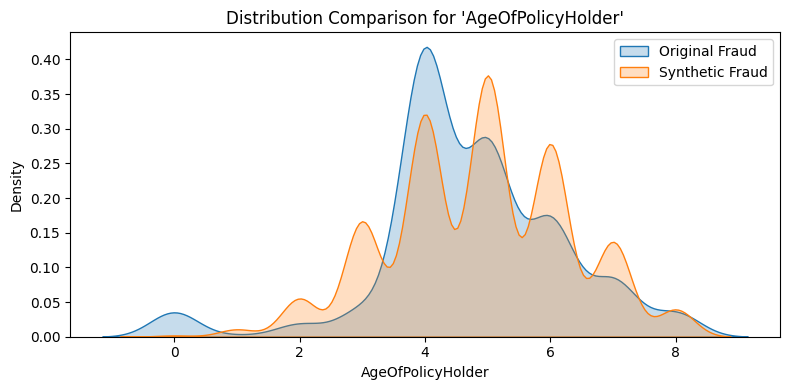

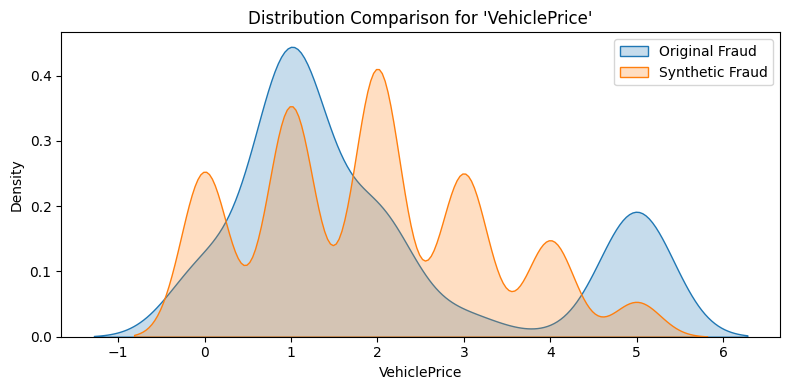

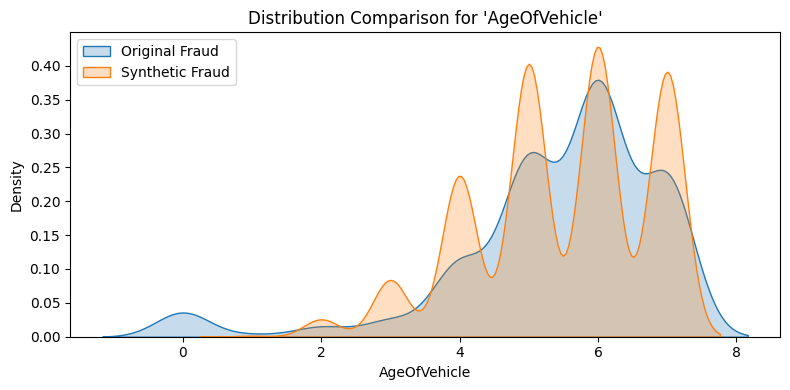

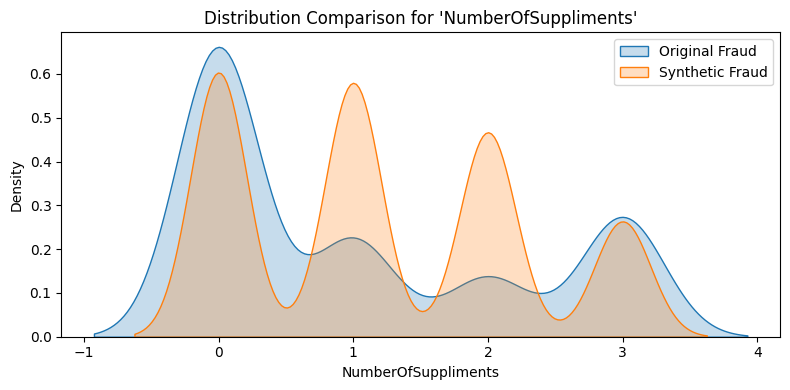

In [19]:
# ---------------------------
# Step 9: Compare Feature Relationships (Real vs Synthetic Fraud)
# ---------------------------


# Separate original and synthetic frauds
original_fraud = df_encoded[df_encoded['FraudFound'] == 'Yes'].copy()
synthetic_fraud = synthetic_fraud.copy()

# Pick a few important features to compare
features_to_compare = ['AgeOfPolicyHolder', 'VehiclePrice', 'AgeOfVehicle', 'NumberOfSuppliments']

for feature in features_to_compare:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(original_fraud[feature], label='Original Fraud', fill=True)
    sns.kdeplot(synthetic_fraud[feature], label='Synthetic Fraud', fill=True)
    plt.title(f"Distribution Comparison for '{feature}'")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Final dataset is ready
augmented_df.to_csv("augmented_fraud_data.csv", index=False)

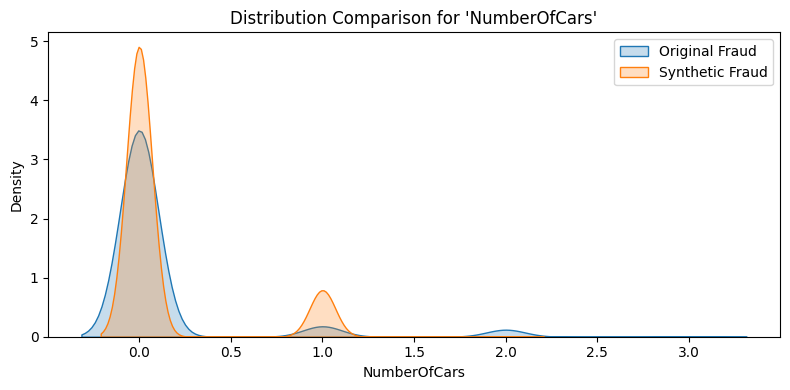

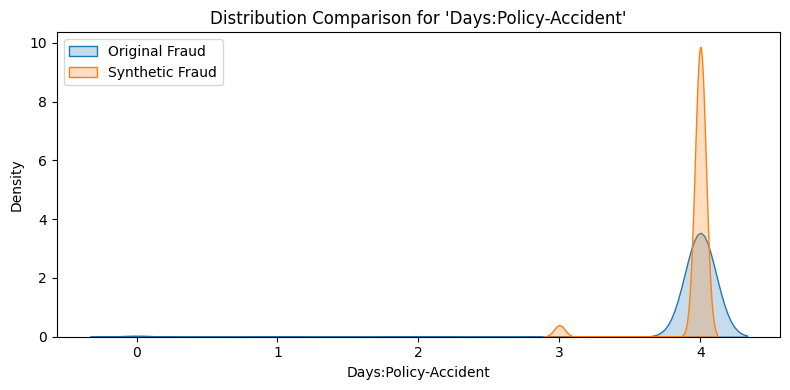

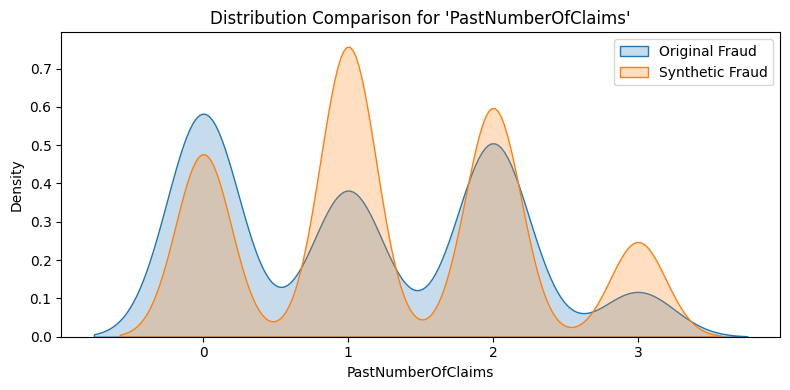

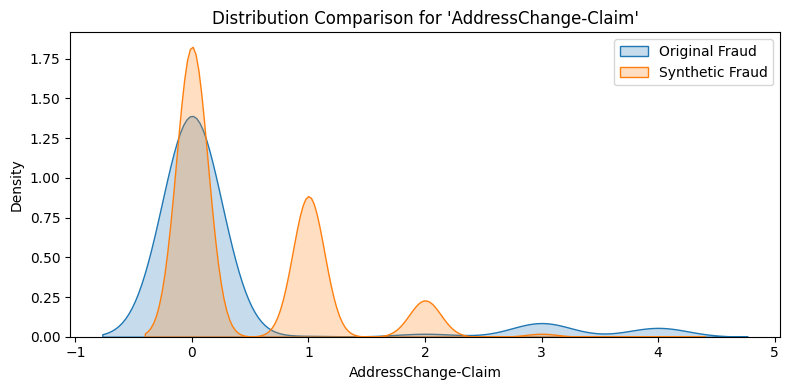

In [20]:
features_to_compare = ['NumberOfCars', 'Days:Policy-Accident', 'PastNumberOfClaims', 'AddressChange-Claim']

for feature in features_to_compare:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(original_fraud[feature], label='Original Fraud', fill=True)
    sns.kdeplot(synthetic_fraud[feature], label='Synthetic Fraud', fill=True)
    plt.title(f"Distribution Comparison for '{feature}'")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
df_encoded['AgeOfPolicyHolder'].unique()

array([3, 4, 6, 7, 2, 5, 0, 8, 1])

In [ ]:
synthetic_fraud['AgeOfPolicyHolder'].unique()

array([5, 6, 7, 3, 4, 8, 2, 1])

In [ ]:
df_encoded['VehiclePrice'].unique()

array([5, 1, 2, 0, 3, 4])

In [ ]:
synthetic_fraud['VehiclePrice'].unique()

array([3, 1, 4, 0, 5, 2])